# 1- Exploratory Data Analysis (Keşifçi Veri Analizi)

## 1.1-Veri Setini İnceleme

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

In [2]:
pd.set_option("display.max_columns", 8)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [3]:
def load_telco():
    data = pd.read_csv("C:/Users/eyp_d/Desktop/VBO-Bootcamp-Dersler/6.Hafta/Ders Öncesi Notlar/datasets/Telco-Customer-Churn.csv")
    return data

In [4]:
df = load_telco()
df.head()

,customerID,gender,SeniorCitizen,Partner,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,...,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,...,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,...,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,...,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,...,Electronic check,70.700,151.65,Yes


In [5]:
df.shape  # Veri seti boyutu 

(7043, 21)

In [6]:
df.info() # Veri seti değişkenler bilgisi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

TotalCharges ve bağımlı değişken veri tipi değiştirildi

In [8]:
df.columns = [col.upper() for col in df.columns]
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,...,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,...,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,...,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,...,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,...,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,...,Electronic check,70.700,151.650,1


Değişken adları kullanım kolaylığı için büyük harflere çevirildi.

## 1.2-Değişkenler Arasındaki Korelasyon Analizi

In [9]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [10]:
binary_cols = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() <= 4] 

In [11]:
df_label = df.copy()

In [12]:
for col in binary_cols:
    df_label = label_encoder(df_label, col).copy()

In [13]:
df_corr = df_label.corr(method ='pearson')

<AxesSubplot:>

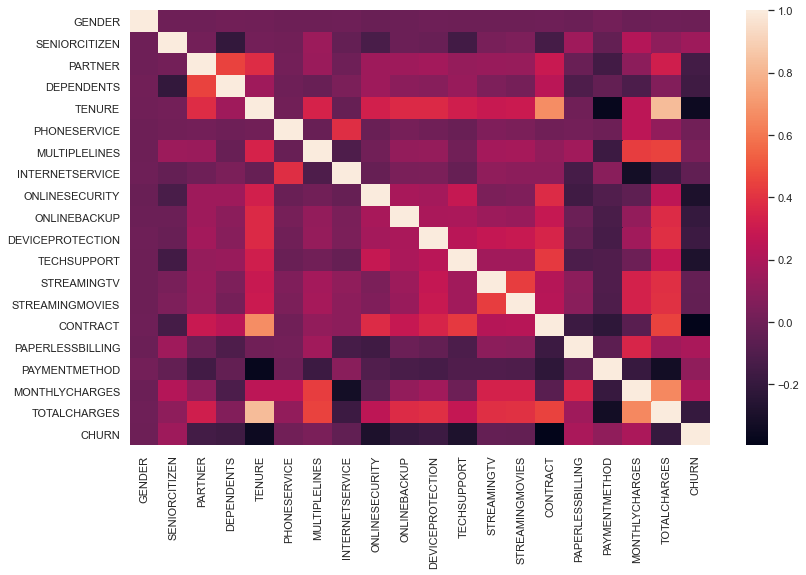

In [14]:
sns.set(rc = {'figure.figsize':(13,8)})
sns.heatmap(df_corr)

## 1.3-Numerik ve Kategorik Değişkenlerin Analizi

grab_col_names() fonksiyonu bir dataframedeki değişkenlerin türlerini göstermek için kullanılır.

In [15]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
  
    return cat_cols, num_cols, cat_but_car

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

### 1.3.1-Kategorik Değişkenlerin Bağımlı Değişkene Göre Analizi

Veri setindeki değişkenlerin bağımlı değişkenle olan korelasyon grafiği incelenerek, yüksek korelasyon değerlerine sahip kategorik değişkenler bu bölümde incelenecektir.

cat_summary() veri setindeki kategorik değişkenlerin dağılımını veren özet fonksiyonudur.

In [17]:
def cat_summary(dataframe, col_name, target_col):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe),
                        f"{target_col}"+"_Mean": df.groupby(col_name)[target_col].mean()}))

cat_analyser_plot() veri setindeki kategorik değişkenlerin dağılımı ve bağımlı değişkenle olan ilişkisini gösteren grafik fonksiyonudur.

In [18]:
def cat_analyser_plot(df, cat_col, target_col):  # Kategorik değişkenlerin bağımlı değişkene göre dağılımını inceleyen plot fonksiyonu
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
      
    df[cat_col].value_counts().plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[0].set_title(f"{cat_col}"+" "+"Dağılımı")
    axes[0].set_xlabel(f"{cat_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    df.groupby(cat_col)[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] )
    axes[1].set_title(f"{cat_col}"+" "+" Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{cat_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.show()

##### SENIORCITIZEN değişkeninin analizi

In [19]:
cat_summary(df, "SENIORCITIZEN", "CHURN")

   SENIORCITIZEN  Ratio  CHURN_Mean
0           5901 83.785       0.236
1           1142 16.215       0.417


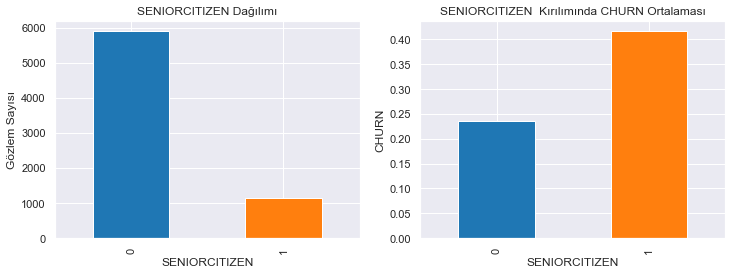

In [20]:
cat_analyser_plot(df,"SENIORCITIZEN","CHURN")

SENIORCITIZEN = 1, yani yaşlı müşterilerin genel dağılımının az olduğu ve CHURN, yani şirketi terk etme ortalamaları oldukça yüksek. Şirketin yaşlı müşterilere yeterince hitap etmediği çıkarımını yapabiliriz.*

##### PARTNER değişkeninin analizi

In [21]:
cat_summary(df, "PARTNER", "CHURN")

     PARTNER  Ratio  CHURN_Mean
No      3641 51.697       0.330
Yes     3402 48.303       0.197


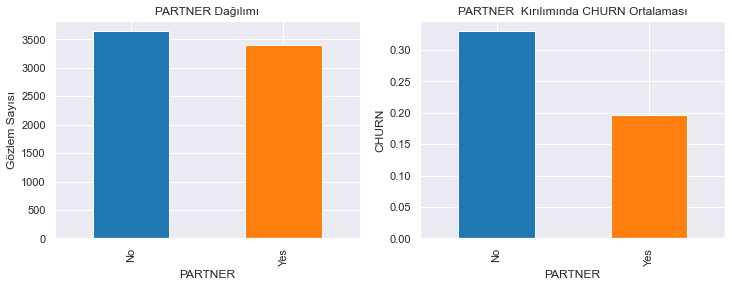

In [22]:
cat_analyser_plot(df,"PARTNER","CHURN")

Bir partneri(evli) olan müşteri dağılımı, olmayanlara eşit olmasına karşın herhangi evli olmayan bir müşterinin churn etme olasılığının daha yüksek olduğu görülebilir.

##### INTERNETSERVICE değişkeninin analizi

In [23]:
cat_summary(df, "INTERNETSERVICE", "CHURN")

             INTERNETSERVICE  Ratio  CHURN_Mean
DSL                     2421 34.375       0.190
Fiber optic             3096 43.959       0.419
No                      1526 21.667       0.074


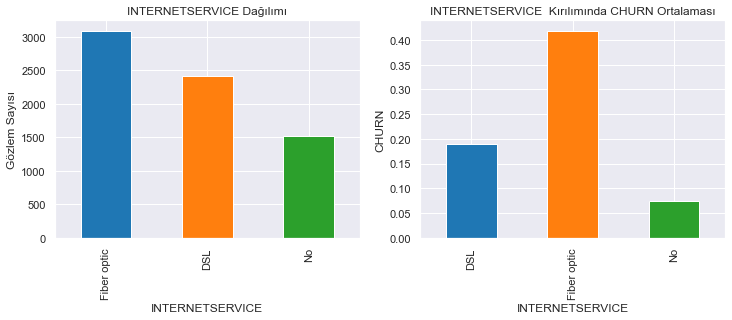

In [24]:
cat_analyser_plot(df,"INTERNETSERVICE","CHURN")

Churn olan müşterilerden internet servisi olarak Fiber Optic kullananların çoğunlukta olduğu görülebilir. Fiber optic internet servisinin müşteriler tarafından beğenilmediği yorumu yapılabilir.

##### DEPENDENTS değişkeninin analizi

In [25]:
cat_summary(df, "DEPENDENTS", "CHURN")

     DEPENDENTS  Ratio  CHURN_Mean
No         4933 70.041       0.313
Yes        2110 29.959       0.155


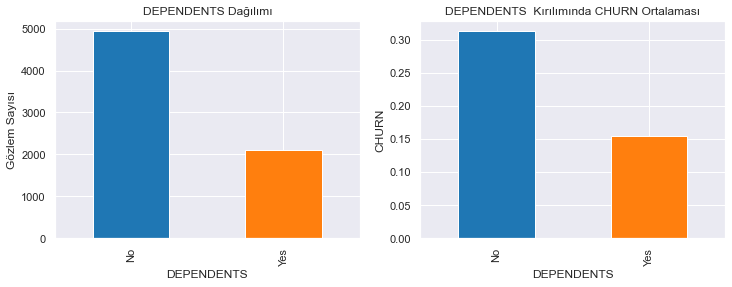

In [26]:
cat_analyser_plot(df,"DEPENDENTS","CHURN")

DEPENDENTS = No, yani bakmakla yükümlü oldukları kimsesi olmayan müşterilerin çoğunluğu oluşturmakta ve churn olmasında etkili olduğu gözlenmektedir.

### 1.3.2-Nümerik Değişkenlerin Bağımlı Değişkene Göre Analizi

Veri setindeki değişkenlerin bağımlı değişkenle olan korelasyon grafiği incelenerek, yüksek korelasyon değerlerine sahip nümerik değişkenler bu bölümde incelenecektir.

In [27]:
num_cols  # Nümerik değişkenler

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

num_summary() veri setindeki nümerik değişkenlerin dağılımını veren özet fonksiyonudur.

In [28]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print("\t\t\t"+f"{numerical_col}"+" Nümerik Değişken İstatistikleri")
    print("\t\t\t---------------------------------------------")
    print(pd.DataFrame(dataframe[numerical_col].describe(quantiles)).T, "\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

num_analyser_plot() veri setindeki nümerik değişkenlerin dağılımı ve bağımlı değişkenle olan ilişkisini gösteren grafik fonksiyonudur.

In [29]:
def num_analyser_plot(df, num_col, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    df[num_col].hist(bins=20, ax=axes[0])
    axes[0].set_title(f"{num_col}"+" "+"Dağılımı")
    axes[0].set_xlabel(f"{num_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    quantiles = [0, 0.25, 0.50, 0.75, 1]
    num_df = df.copy()
    num_df[f"{num_col}"+"_CAT"] = pd.qcut(df[num_col], q=quantiles) # nümerik değişken kategorize edildi.
    
    num_df.groupby(f"{num_col}"+"_CAT")[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[1].set_title(f"{num_col}"+" "+" Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{num_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.xticks(rotation=0)
    plt.show()

##### TENURE değişkeninin analizi

In [30]:
num_summary(df, "TENURE")

			TENURE Nümerik Değişken İstatistikleri
			---------------------------------------------
          count   mean    std   min  ...    90%    95%    99%    max
TENURE 7043.000 32.371 24.559 0.000  ... 69.000 72.000 72.000 72.000

[1 rows x 17 columns] 



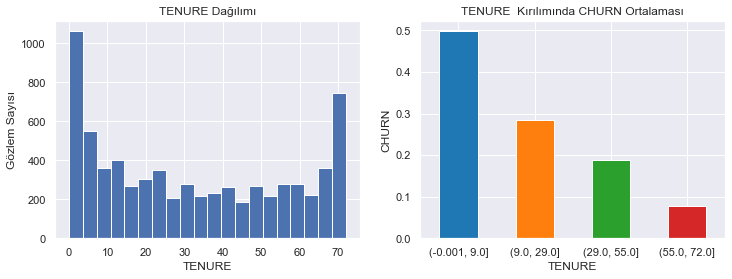

In [31]:
num_analyser_plot(df, "TENURE", "CHURN")

TENURE, yani müşterilerin şirkette kaldığı süreyi ifade eden değişken incelendiğinde çoğunluğun 0-4 ay aralığında kaldığı görülebilir. TENUR sayısının düşük olduğu yani, en fazla yeni müşterilerin şirketi terk etme potansiyelinde olduğu görülebilir. 

##### MONTHLYCHARGES değişkeninin analizi

In [32]:
num_summary(df, "MONTHLYCHARGES")

			MONTHLYCHARGES Nümerik Değişken İstatistikleri
			---------------------------------------------
                  count   mean    std    min  ...     90%     95%     99%     max
MONTHLYCHARGES 7043.000 64.762 30.090 18.250  ... 102.600 107.400 114.729 118.750

[1 rows x 17 columns] 



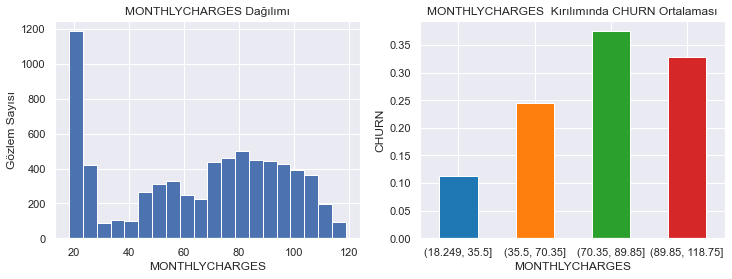

In [33]:
num_analyser_plot(df, "MONTHLYCHARGES", "CHURN")

Müşterilerden aylık olarak tahsil edilen tutarların dağılımı baskın bir şekilde 20-25 bandında iken CHURN oranının ortalması daha çok 70-90 bandında gözükmektedir. Yani, şirketi terk eden müşterilerin çoğunluğu yüksek aylık ücret tahsil edilenler diyebiliriz.

##### TOTALCHARGES değişkeninin analizi

In [34]:
num_summary(df, "TOTALCHARGES")

			TOTALCHARGES Nümerik Değişken İstatistikleri
			---------------------------------------------
                count     mean      std    min  ...      90%      95%      99%      max
TOTALCHARGES 7032.000 2283.300 2266.771 18.800  ... 5976.640 6923.590 8039.883 8684.800

[1 rows x 17 columns] 



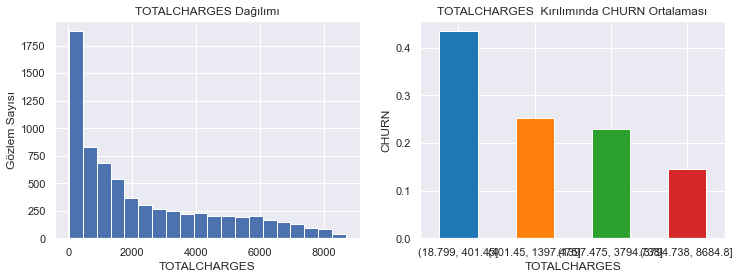

In [35]:
num_analyser_plot(df, "TOTALCHARGES", "CHURN")

Şirketi terk eden müşterilerin toplam ödedikleri ücretler incelendiğinde giriş seviyesi toplam ücret ödeme yapmış müşterilerin şirketi terk ettiği görülebilir.

## 1.4-Aykırı Gözlem Analizi

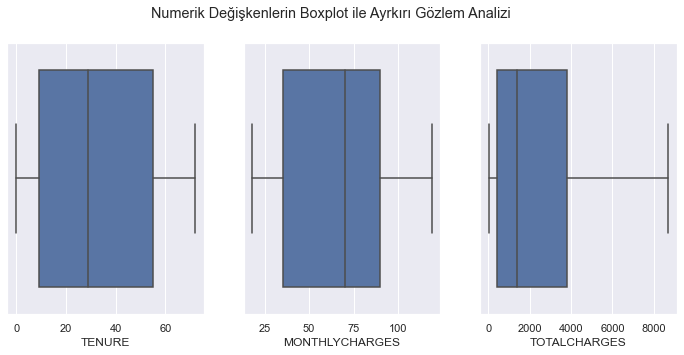

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Numerik Değişkenlerin Boxplot ile Ayrkırı Gözlem Analizi')
sns.boxplot(x=df["TENURE"], ax=axes[0])
sns.boxplot(x=df["MONTHLYCHARGES"], ax=axes[1])
sns.boxplot(x=df["TOTALCHARGES"], ax=axes[2])
plt.show() 

Değişkenlerde aykırı değer gözükmemektedir.

##### Sayısal olarak inceleme

Değişkenin outlier threshold değerlerini hesaplayan fonksiyon.

In [37]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

Değişkende outlier olup olmadığını dönen fonksiyon.

In [38]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [39]:
for col in num_cols:
    print(f"{col}:", check_outlier(df, col))

TENURE: False
MONTHLYCHARGES: False
TOTALCHARGES: False


## 1.5-Eksik Gözlem Analizi

In [40]:
df.isnull().values.any() # Veri setinde eksik gözlem(missing value) var mı?

True

Missing value gözlem değerlerine sahip değişkenler var.

missing_values_table(), missing value gözlemlere sahip değişkenleri, missing value sayısını ve ortalamasını dönen fonksiyon

In [41]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [42]:
missing_values_table(df, na_name=True)

              n_miss  ratio
TOTALCHARGES      11  0.160


['TOTALCHARGES']

# 2-Feature Engineering (Özellik Mühendisliği)

Buraya kadarki kısım, Veri setine ilk bakışla ilgiliydi. EDA olarak da tanımlanan buraya kadarki kısımda veri üzerinde herhangi bir değişiklik yapılmadı.

Görev-2 ile birlikte veri seti, geliştirilecek model için sayısallaştırılacaktır.

## 2.1-Eksik ve Aykırı Değerleri Düzeltme

Keşifçi Veri Analizi bölümünde görüldüğü üzere veri setinin herhangi bir değişkeninde outlier bulunmamaktadır.

TOTALCHARGES değişkeninde bulunan missing value gözlemleri, değişkene ait median değeriyle baskılandı.

In [43]:
df["TOTALCHARGES"].fillna(df["TOTALCHARGES"].median(), inplace=True) 

In [44]:
df.isnull().values.any() # Missing value gözleme sahip değişken kalmadı.

False

## 2.2-Yeni Değişkenler Oluşturma

Bu bölümde, Keşifçi Veri Analizi bölümünde ele alınan değişkenlerin bağımlı değişken ile olan ilişkisi üzerinden, yeni değişkenler türetme aşamasıdır.

Var olan değişkenler üzerinden türetilecek olan yeni değişkenlerle, bağımlı değişken ile arasında anlamlı çıkarımlar kurulması amaçlanacaktır.

In [45]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,...,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,7590-VHVEG,Female,0,Yes,...,Electronic check,29.850,29.850,0
1,5575-GNVDE,Male,0,No,...,Mailed check,56.950,1889.500,0
2,3668-QPYBK,Male,0,No,...,Mailed check,53.850,108.150,1
3,7795-CFOCW,Male,0,No,...,Bank transfer (automatic),42.300,1840.750,0
4,9237-HQITU,Female,0,No,...,Electronic check,70.700,151.650,1


##### TENURE Değişkeni Segmentasyonu

TENUR değişkenindeki değerlere göre basit müşteri segmentasyonunu yapar.

In [46]:
df.loc[(df['TENURE'] <= 6), 'NEW_TENURE'] = 'new_customer'
df.loc[(df['TENURE'] > 6) & (df['TENURE'] <= 18), 'NEW_TENURE']  = "potential_loyalists"
df.loc[(df['TENURE'] > 18) & (df['TENURE'] <= 54), 'NEW_TENURE'] = 'loyal_customer'
df.loc[(df['TENURE'] > 54), 'NEW_TENURE'] = 'champions'

##### MONTHLYCHARGES Değişkeni Segmentasyonu

TENUR değişkenindeki değerlere göre müşterinin aldığı hizmetin segmentasyonunu yapar.

In [47]:
df.loc[(df['MONTHLYCHARGES'] <= 25), 'NEW_MONTHLYCHARGES'] = 'simple_packg'
df.loc[(df['MONTHLYCHARGES'] > 25) & (df['MONTHLYCHARGES'] <= 45), 'NEW_MONTHLYCHARGES']  = "normal_packg"
df.loc[(df['MONTHLYCHARGES'] > 45) & (df['MONTHLYCHARGES'] <= 70), 'NEW_MONTHLYCHARGES'] = 'gold_packg'
df.loc[(df['MONTHLYCHARGES'] > 70), 'NEW_MONTHLYCHARGES'] = 'ultra_packg'

##### Loyal ve yaşlı olmayan müşteriler

In [48]:
df["NEW_LoyalYoung"] = df.apply(lambda x: 1 if (x["SENIORCITIZEN"] == 0) 
                                     and (x["NEW_TENURE"] == "loyal_customer" or x["NEW_TENURE"] == "champions") else 0, axis=1)

##### Genç olup streaming servislerini kullanan müşteriler

In [49]:
df["NEW_YoungStreaming"] = df.apply(lambda x: 1 if (x["SENIORCITIZEN"] == 0) 
                                     and (x["STREAMINGTV"] == "Yes") and (x["STREAMINGMOVIES"] == "Yes") else 0, axis=1)

##### Ödemeleri otomatik ödeme yoluyla yapanlar

In [50]:
df["NEW_AutoPayment"] = df["PAYMENTMETHOD"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

##### Genç olup, bakmak durumunda kaldığı kişileri olmayan müşteriler

In [51]:
df["NEW_YoungUndependent"] = df.apply(lambda x: 1 if(x["SENIORCITIZEN"] == 0) and (x["DEPENDENTS"] == "No") else 0, axis=1)

##### Evli olup, bakmak durumunda kaldığı kişileri olan müşteriler

In [52]:
df["NEW_PartnerDependent"] = df.apply(lambda x: 1 if(x["PARTNER"] == "Yes") and (x["DEPENDENTS"] == "Yes") else 0, axis=1)

##### Evli olup, loyal seviye olan müşteriler

In [53]:
df["NEW_PartnerLoyal"] = df.apply(lambda x: 1 if(x["PARTNER"] == "Yes") 
                                      and (x["NEW_TENURE"] == "loyal_customer"
                                        or x["NEW_TENURE"] == "champions") else 0, axis=1)

##### Müşterinin toplam aldığı servis sayısı

In [54]:
df['NEW_TotalServices'] = (df[['PHONESERVICE', 'INTERNETSERVICE', 'ONLINESECURITY',
                                 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT',
                                 'STREAMINGTV', 'STREAMINGMOVIES']]== 'Yes').sum(axis=1)

##### Müşterinin servis başına ödediği ücret 

In [55]:
df["NEW_AVG_Service_Fee"] = df["MONTHLYCHARGES"] / (df['NEW_TotalServices'] + 1)

##### 1 veya 2 yıllık kontrat imzalamış müşteriler

In [56]:
df["NEW_Engaged"] = df["CONTRACT"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [57]:
df.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,...,NEW_PartnerLoyal,NEW_TotalServices,NEW_AVG_Service_Fee,NEW_Engaged
0,7590-VHVEG,Female,0,Yes,...,0,1,14.925,0
1,5575-GNVDE,Male,0,No,...,0,3,14.238,1
2,3668-QPYBK,Male,0,No,...,0,3,13.463,0
3,7795-CFOCW,Male,0,No,...,0,3,10.575,1
4,9237-HQITU,Female,0,No,...,0,1,35.350,0


## 2.3-Encoding işlemlerini gerçekleştirme.

Bu bölüm, veri setindeki kategorik değişkenlerin model tarafından anlaşılabilir formatta olacak şekilde encode edilmesi aşamasıdır. Sırasıyla Label Encoding, Rare Encoding ve One-Hot Encoding işlemleri yapılacaktır.

### 2.3.1-Label Encoder

2 farklı deişkene sahip kategorik değişkenlerin binary(0-1) haline çevrilmesi aşamasıdır.

In [58]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [59]:
binary_cols = [col for col in df.columns if df[col].dtype == "O" and df[col].nunique() == 2] #
binary_cols

['GENDER', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'PAPERLESSBILLING']

In [60]:
for col in binary_cols:
    df = label_encoder(df, col)
df.head(2)

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,...,NEW_PartnerLoyal,NEW_TotalServices,NEW_AVG_Service_Fee,NEW_Engaged
0,7590-VHVEG,0,0,1,...,0,1,14.925,0
1,5575-GNVDE,1,0,0,...,0,3,14.238,1


### 2.3.2-Rare Encoding

Bağımlı değişkene göre dağılımı seyrek olan değişken gözlemlerinin birarada encode edilmesidir. 

In [61]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [62]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [63]:
rare_analyser(df, "CHURN", cat_cols)

Rare olarak kabul edilebilecek herhangi bir değişken gözlemi gözükmüyor. 

### 2.3.3-One-Hot Encoding

2'den fazla benzersiz(uniq) gözleme sahip kategorik değişkenlerin encode edilmesi aşamasıdır. 

In [64]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]  # One-Hot encoding için uygun değişkenler
ohe_cols

['MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAYMENTMETHOD',
 'NEW_TENURE',
 'NEW_MONTHLYCHARGES',
 'NEW_TotalServices']

In [65]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [66]:
df = one_hot_encoder(df, ohe_cols)

In [67]:
df.head(3)    # Encoding sonrası veri seti

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,...,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7
0,7590-VHVEG,0,0,1,...,0,0,0,0
1,5575-GNVDE,1,0,0,...,0,0,0,0
2,3668-QPYBK,1,0,0,...,0,0,0,0


In [68]:
df.shape

(7043, 53)

## 2.4-Numerik Değişkenler için Standartlaştırma İşlemi

In [69]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)  # Nümerik değişkenler
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES', 'NEW_AVG_Service_Fee']

In [70]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [71]:
df[num_cols].head()  # Nümerik değişkenler standartlaştırıldı.

,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_Service_Fee
0,-1.277,-1.160,-0.994,-0.311
1,0.066,-0.260,-0.173,-0.410
2,-1.237,-0.363,-0.960,-0.522
3,0.514,-0.747,-0.195,-0.939
4,-1.237,0.197,-0.940,2.636


In [72]:
df.head(3)  # Standartlaştırma sonrası veri seti

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,...,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7
0,7590-VHVEG,0,0,1,...,0,0,0,0
1,5575-GNVDE,1,0,0,...,0,0,0,0
2,3668-QPYBK,1,0,0,...,0,0,0,0


# 3-Model oluşturma ve Test

Bu aşamada, Keşifçi Veri Analizi ve Özellik Mühendisliği bölümlerinde hazırlanan veri seti üzerinde basit sınıflandırma modeli geliştirilecek olup konunun detaylarına(model metrik optimizasyonu) girilmeden, test süreci gerçekleştirilecektir.

Sonuç olarak, hazırlanan veri seti ile model metriklerinin sonuçları ve model için anlamlı/önemli değişkenler incelenecektir.

In [73]:
df.drop("CUSTOMERID", inplace=True, axis=1) # Modelin oluşturulmasında anlamlı bilgi taşımayan CUSTIOMERID değişkeni silindi.

Genel Bakış

In [74]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,...,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7
0,0,0,1,0,...,0,0,0,0
1,1,0,0,0,...,0,0,0,0
2,1,0,0,0,...,0,0,0,0
3,1,0,0,0,...,0,0,0,0
4,0,0,0,0,...,0,0,0,0


In [75]:
df.shape   # Model öncesi veri setinin son büyüklüğü

(7043, 52)

In [76]:
y = df["CHURN"]
X = df.drop(["CHURN"], axis=1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [78]:
catboost_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [79]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")  # Modele ait ölçüm metriklerinin değerleri
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.64
Precision: 0.52
F1: 0.58
Auc: 0.74


plot_feature_importance(), model için önemli/anlamlı bilgi içeren değişkenlerin grafiksel olarak gösteren fonksiyondur.

In [80]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(20, 18))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

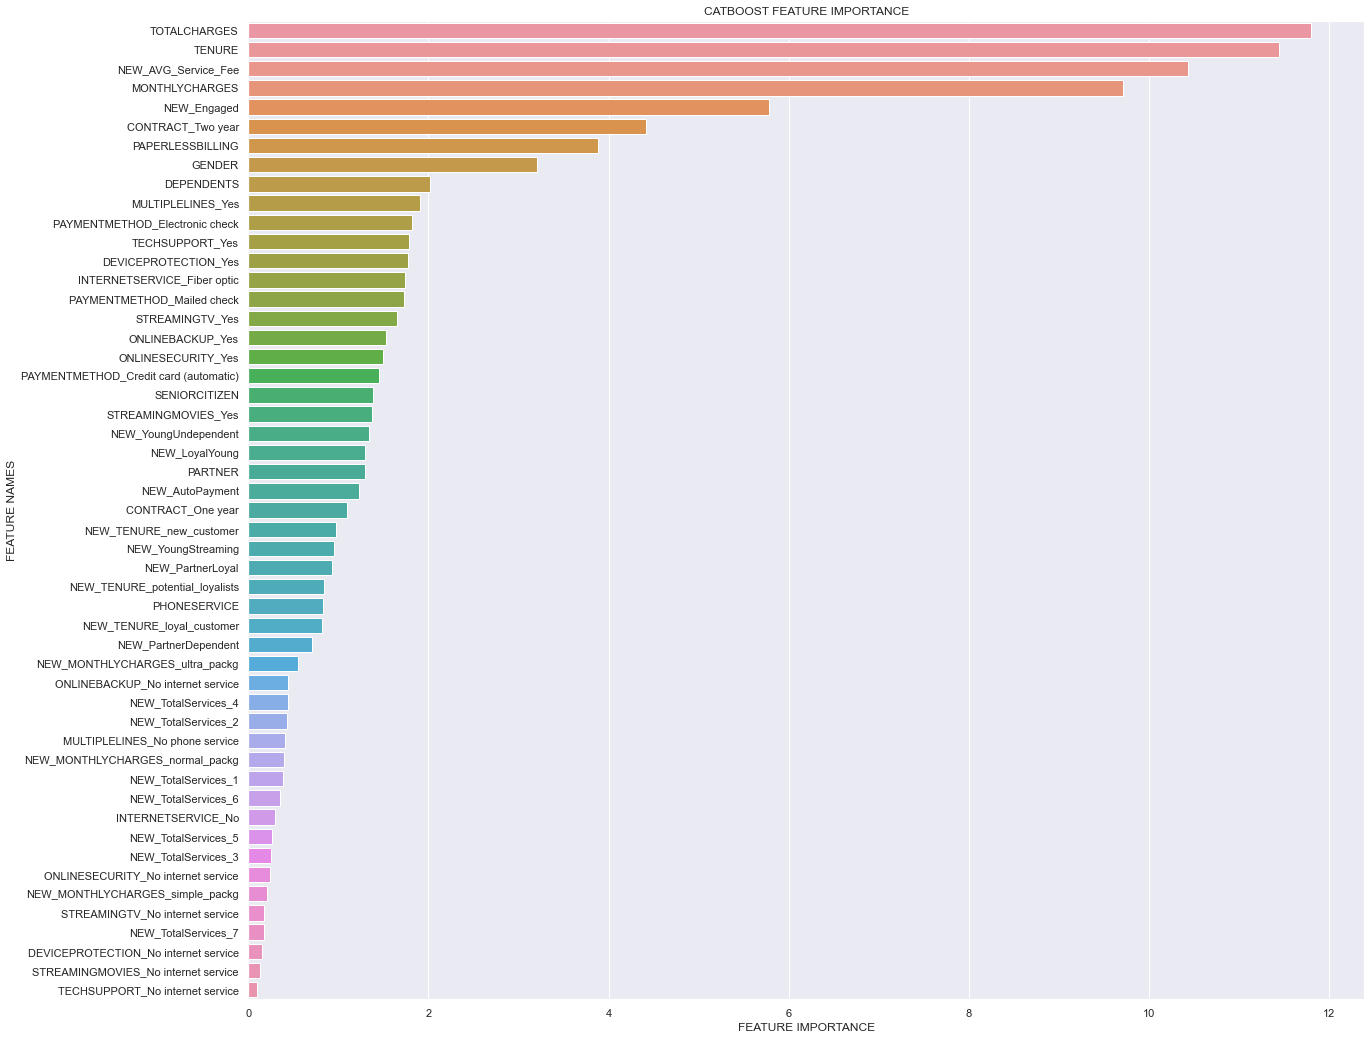

In [81]:
plot_feature_importance(catboost_model.get_feature_importance(), X.columns, 'CATBOOST')

## Sonuç
Yukarıdaki grafikten, müşteri terk senaryosu için önemli/anlamlı bilgi içeren değişkenler incelenebilir. Buna göre, Feature Extraction ve Encoding aşamalarında üretilen yeni değişkenlerin de modelin anlamlılığı üzerindeki etkisi görülebilir. 

Model için önemli değişkenler gözönünde bulundurularak, iş modelleri geliştirilebilir.

#### Kaynakça: 
Veri Bilimi Okulu:   
https://www.veribilimiokulu.com/